In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [530]:
df = pd.read_csv('train_groups.csv')

In [436]:
df.head()

,pair_id,group_id,doc_id,clean_title_x,dev,target,clean_title_y
0,11691,130,6710,как прописывать админк себя или друг,0.568197,1,как прописывать админк себя или друг
1,11692,130,4030,скачать доработка слива мода готовый сервер дл...,0.633603,0,скачать доработка слива мода готовый сервер дл...
2,11693,130,5561,как прописывать админка каталог статья игровой...,0.512329,1,как прописывать админка каталог статья игровой...
3,11694,130,4055,как прописывать простой админка,0.379296,1,как прописывать простой админка
4,11695,130,4247,подбор админ для сервер код архив форум,0.635060,0,подбор админ для сервер код архив форум


In [226]:
grouped_data = df.groupby('group_id')

(array([45., 24.,  5.,  4.,  2.,  3.,  1.,  4.,  2.,  3.,  1.,  3.,  6.,
         2.,  7.,  2.,  1.,  5.,  3.,  6.]),
 array([0.03809524, 0.08469048, 0.13128571, 0.17788095, 0.22447619,
        0.27107143, 0.31766667, 0.3642619 , 0.41085714, 0.45745238,
        0.50404762, 0.55064286, 0.5972381 , 0.64383333, 0.69042857,
        0.73702381, 0.78361905, 0.83021429, 0.87680952, 0.92340476,
        0.97      ]),
 <a list of 20 Patch objects>)

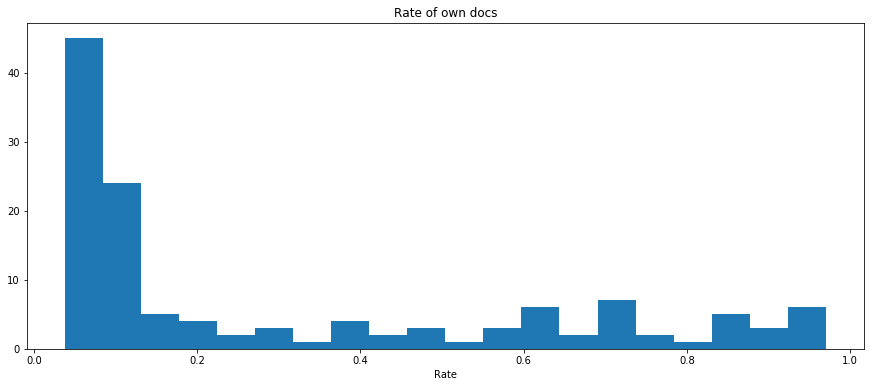

In [227]:
rate_of_own = grouped_data['target'].sum() / grouped_data['target'].count()
plt.figure(figsize=(15, 6))
plt.title("Rate of own docs")
plt.xlabel("Rate")
plt.hist(rate_of_own, bins=20)

In [228]:
rate_of_own.describe()

count    129.000000
mean       0.308377
std        0.305106
min        0.038095
25%        0.075472
50%        0.106383
75%        0.585106
max        0.970000
Name: target, dtype: float64

Можем видеть, что доля документов, относящихся к теме у разных групп сильно отличается (от 0.04 до 0.97), однако в большей части групп преобладают документы, не относящиеся к ним.

Text(0.5, 0, 'Docs in group')

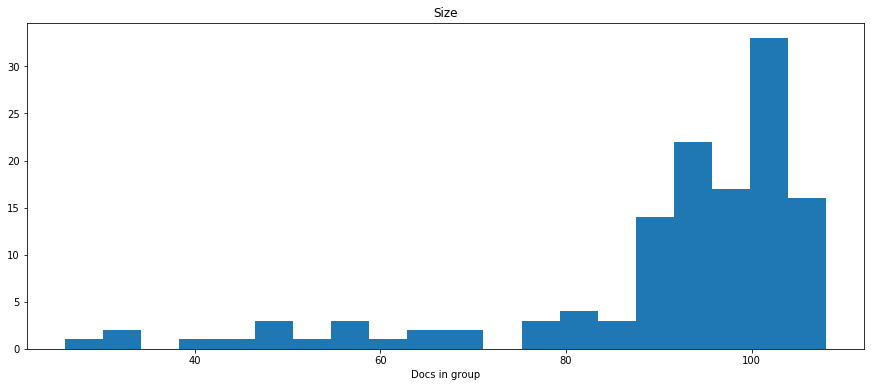

In [229]:
count = grouped_data['target'].count()
plt.figure(figsize=(15, 6))
plt.hist(count, bins=20)
plt.title("Size")
plt.xlabel("Docs in group")

In [230]:
count.describe()

count    129.000000
mean      90.620155
std       17.409226
min       26.000000
25%       88.000000
50%       96.000000
75%      102.000000
max      108.000000
Name: target, dtype: float64

По большей части около 100, но есть и совсем маленькие.

In [231]:
titles = pd.read_csv('docs_titles.tsv', sep='\t')

In [232]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   doc_id  27950 non-null  int64 
 1   title   27919 non-null  object
dtypes: int64(1), object(1)
memory usage: 436.8+ KB


In [233]:
titles['len'] = titles['title'].apply(lambda x: len(str(x)))

In [234]:
titles['len'].describe()

count    27950.000000
mean        62.113238
std         47.701476
min          1.000000
25%         36.000000
50%         54.000000
75%         77.000000
max       1786.000000
Name: len, dtype: float64

Text(0.5, 0, 'n_char')

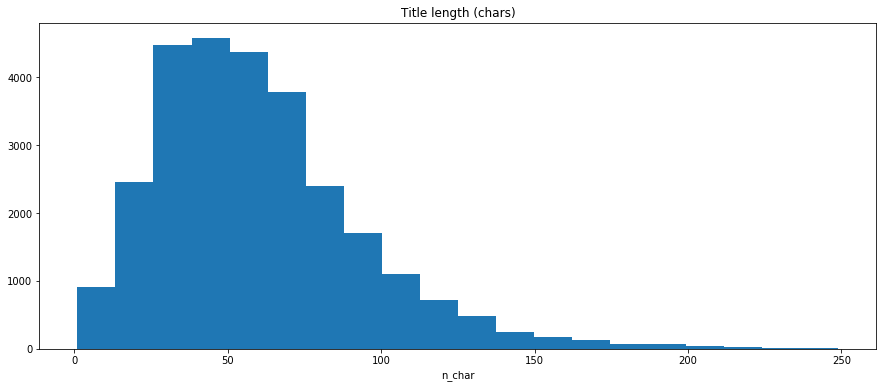

In [235]:
plt.figure(figsize=(15, 6))
plt.hist(titles[titles['len'] < 250]['len'], bins=20)
plt.title("Title length (chars)")
plt.xlabel("n_char")

Большая часть заголовков по длине в символах распределена в пределах 0 - 250.

In [236]:
titles['n_words'] = titles['title'].apply(lambda x: len(str(x).split(' ')))

In [237]:
titles['n_words'].describe()

count    27950.000000
mean         9.294812
std          7.712129
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max        247.000000
Name: n_words, dtype: float64

Text(0.5, 0, 'n_word')

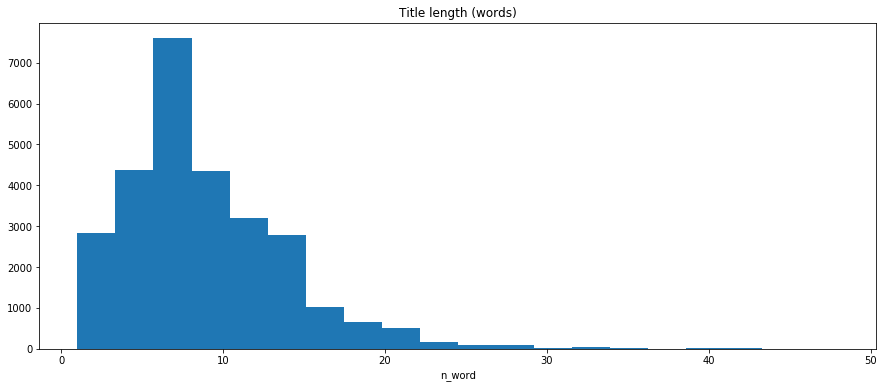

In [238]:
plt.figure(figsize=(15, 6))
plt.hist(titles[titles['n_words'] < 50]['n_words'], bins=20)
plt.title("Title length (words)")
plt.xlabel("n_word")

Похожее распределение у длины в словах.

# Заигрывания с векторами

In [3]:
df = pd.read_csv('train_groups.csv')

In [4]:
titles = pd.read_csv('clean_titles.csv')

In [5]:
vectorizer = CountVectorizer(min_df=2, max_features=5000)
# vectorizer = TfidfVectorizer(min_df=2)
data_vect = vectorizer.fit_transform(titles['clean_title'].fillna('')).todense()

In [6]:
scaler = StandardScaler()
data_vect = scaler.fit_transform(data_vect)

In [7]:
titles = titles.join(pd.DataFrame(data_vect))

In [8]:
df = pd.merge(df, titles, how='left', on='doc_id')

In [9]:
df_list = []
for i in tqdm(df['group_id'].unique(), total=129):
    df_i = df[df['group_id'] == i]
    vect_i = np.array(df_i.loc[:, [j for j in range(data_vect.shape[1])]])
    mean_i = np.mean(vect_i, axis=0)
    df_i['dev'] = np.apply_along_axis(lambda x: cosine(x, mean_i), axis=1, arr=vect_i)
    df_list.append(df_i)
df_with_dev = pd.concat(df_list)

In [10]:
df = df_with_dev.drop([i for i in range(data_vect.shape[1])], 1)

In [11]:
df.head()

,pair_id,group_id,doc_id,target,clean_title,dev
0,1,1,15731,0,ваз замена подшипник ступица нива,0.192742
1,2,1,14829,0,ваз опт сочи сравнивать цена купить потребител...,0.743772
2,3,1,15764,0,купить ступица лада калина трансмиссия переход...,0.701853
3,4,1,17669,0,классика,0.969549
4,5,1,14852,0,ступица нива замена подшипник свой рука,0.290637


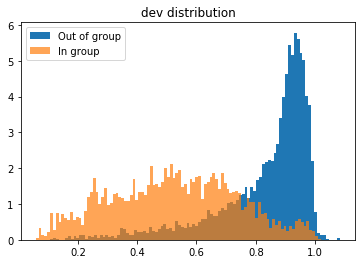

In [12]:
plt.hist(df[df['target'] == 0]['dev'], bins=100, normed=True, label='Out of group')
plt.hist(df[df['target'] == 1]['dev'], bins=100, normed=True, alpha=0.7, label='In group')
plt.title('dev distribution')
plt.legend();

In [13]:
X_train = np.array(df[df['group_id'] <= 65]['dev'].fillna(0)).reshape(-1, 1)
X_test = np.array(df[df['group_id'] > 65]['dev'].fillna(0)).reshape(-1, 1)
y_train = np.array(df[df['group_id'] <= 65]['target'])
y_test = np.array(df[df['group_id'] > 65]['target'])

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)
proba = model.predict_proba(X_test)
print(roc_auc_score(y_test, proba[:, 1]))

0.8750339180129211


In [15]:
scores = []
ths = np.arange(0.1, 0.9, 0.1)
for i in ths:
    scores.append(f1_score(y_test, (proba > i)[:, 1]))
ind = scores.index(max(scores))
th = np.arange(0.1, 0.9, 0.1)[ind]
score = f1_score((proba > th)[:, 1], y_test)
print(score)

0.7113374430447601


In [16]:
X = np.array(df['dev'].fillna(0)).reshape(-1, 1)
y = np.array(df['target'])

In [17]:
for i in np.arange(0, 1, 0.05):
    print(i, f1_score((X < i), y))

0.0 0.0
0.05 0.0
0.1 0.014180206794682423
0.15000000000000002 0.06605399195864446
0.2 0.12223451327433628
0.25 0.19263157894736843
0.30000000000000004 0.2909090909090909
0.35000000000000003 0.36393063583815033
0.4 0.4305495456512332
0.45 0.49828939424431473
0.5 0.5631392970057653
0.55 0.6253636830395345
0.6000000000000001 0.6652839821314614
0.65 0.6947430422618172
0.7000000000000001 0.7147496617050069
0.75 0.7116244411326379
0.8 0.6905982905982905
0.8500000000000001 0.6491101738504269
0.9 0.5853747051351842
0.9500000000000001 0.4950048824457297


In [18]:
df = pd.read_csv('test_groups.csv')
df.head()

,pair_id,group_id,doc_id
0,11691,130,6710
1,11692,130,4030
2,11693,130,5561
3,11694,130,4055
4,11695,130,4247


In [19]:
df = pd.merge(df, titles, how='left', on='doc_id')

In [20]:
df_list = []
for i in tqdm(df['group_id'].unique(), total=129):
    df_i = df[df['group_id'] == i]
    vect_i = np.array(df_i.loc[:, [j for j in range(data_vect.shape[1])]])
    mean_i = np.mean(vect_i, axis=0)
    df_i['dev'] = np.apply_along_axis(lambda x: cosine(x, mean_i), axis=1, arr=vect_i)
    df_list.append(df_i)
df_with_dev = pd.concat(df_list)

In [21]:
df = df_with_dev.drop([i for i in range(data_vect.shape[1])], 1)

In [22]:
df['target'] = df['dev'].apply(lambda x: int(x < 0.7))

In [23]:
df.loc[:, ['pair_id', 'target']].to_csv('sub_16_2_05.csv', index=False)

# Продолжаем анализ